## Beyond The VIF: Collinearity Analysis for Bias Mitigation and Predictive Accuracy

- https://towardsdatascience.com/beyond-the-vif-collinearity-analysis-for-bias-mitigation-and-predictive-accuracy-18fbba3f7aa2

In [1]:
import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy import stats
import warnings; warnings.filterwarnings('ignore')
#plt.style.use('ggplot')
plt.style.use('seaborn-whitegrid')
%matplotlib inline

대부분의 머신러닝 알고리즘은 예측 정확도를 최적화하기 위해 최상의 피처 조합을 선택합니다.  
따라서 상관관계가 있더라도 학습에서 관찰된 상관관계가 실제 세계에서도 그대로 유지된다면 머신러닝에서 상관관계는 문제가 되지 않습니다.   
그러나 모델의 설명력을 고려할 때, 상관관계의 확인되지 않은 효과는 잠재적인 편향의 원인이 될 수 있습니다.

데이터 집합에서 독립 변수(IV) 간의 높은 상관관계는 회귀 모델을 해석할 때 종종 문제를 야기합니다.   
특히 데이터 관계의 진정한 원인을 파악하는 데 방해가 되어 편향된 해석과 부당한 의사 결정으로 이어질 수 있습니다.   
예를 들어, 그림 1에서 독립 변수(TAX), (B) 및 (RAD)는 공선형 IV이며 종속 변수(MEDV)의 좋은 예측 변수이기도 합니다.    
ML 알고리즘은 최적의 예측자 조합을 선택하지만, 이 세 가지 변수가 있는 모델에 다른 공선형 변수(RM)를 추가하는 효과를 고려하지 못할 수도 있습니다.

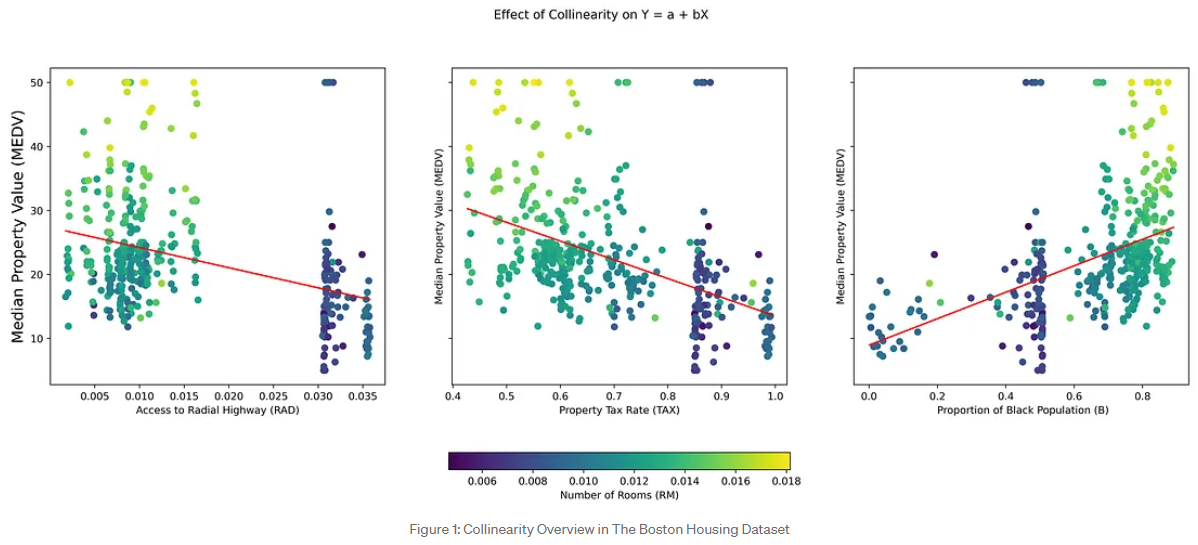

모델이 상관관계 분석을 전처리 단계로 진지하게 받아들이도록 유도하려면,  
상관관계 변수를 유지하는 데 드는 inflationary cost와 이를 삭제하는 데 드는 predictive cost의 균형을 맞출 수 있는 방법이 있어야 합니다.

### Understanding Collinearity

확인되지 않은 상관관계가 어떻게 의도하지 않은 bias으로 이어지는지 보여주기 위해 보스턴 주택 데이터셋을 예로 들어보겠습니다.   
이 데이터 집합은 'non-inveratable' 변수 'B'를 포함하고 있다는 사실이 밝혀져 공개적으로 사용되지 않고 있습니다.  
독립 변수 "B", "RM", "TAX" 간의 선형 관계는 가짜 상관관계가 독립변수 간의 실제 관계를 어떻게 억제하는지를 보여주는 완벽한 사례입니다.   
"B"에 대한 '반전 불가능' 변환(연속형 IV로 가장한 binary IV)은 ML 알고리즘이 포착하지 못할 수 있는 bias를 완화합니다.

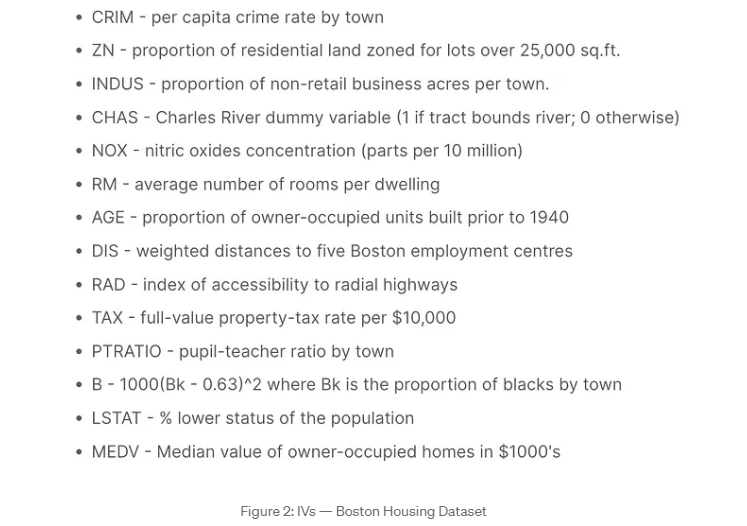

이 데이터셋에는 13개의 IV가 있고, 한 도시 주택의 중앙 가격(MEDV)를 타겟 또는 종속변수(DV)로 간주한다.  
특정 피처가 강력한 결과 예측 인자로 보이지만, 이러한 영향력은 그 분산이 다른 예측자에 의해 대부분 설명된다는 데 있습니다.

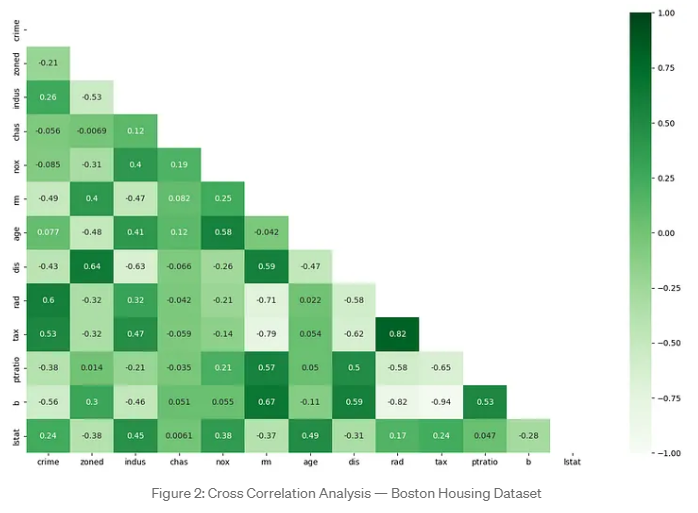

독립변수와 종속변수 간의 이변량(bivariate) 관계에서 새로운 독립변수가 도입되면 네 가지 가능성 중 하나가 발생할 수 있습니다:   

- 가짜 인플레이션(Spurious inflation): 세 번째 독립 변수를 포함하면 첫 번째 독립 변수가 DV에 미치는 영향이 크게 확대됩니다.
- 마스킹 또는 억제(Masking or suppression): 새 IV가 초기 IV와 종속 변수에 대한 영향을 숨기거나 억제합니다.
- 조정 또는 변경(Moderates or alters): 새 변수가 독립 변수의 모든 또는 일부 관찰에 대한 원래 관계의 방향을 변경합니다.
- 효과 없음: 세 번째 IV는 새로운 정보를 제공하지 않으며 IV와 DV에 영향을 미치지 않습니다.   

모델링을 할때 공선성 제거를 위한 기존의 솔루션은 예측력 손실, 과적합 모델, 편향성(bias)을 초래할 수가 있다.   
따라서 정보 손실을 완화하는 솔루션이 필요하다.

### Evaluating Collinearity

두 개 이상의 독립 변수가 상관관계가 높은 경우(RAD와 TAX), 
이 것의 직관적 의미는 어떤 '잠재적' 개념(큰 교외 주택/도시 아파트)이 종속(타겟) 변수(부동산 가치)에 미치는 영향에 대해 정확히 동일한 정보를 제공할 가능성이 있다는 것입니다.   
'재산세'가 있는 경우, 방사형 고속도로에 대한 접근성은 재산 가치에 새로운 정보를 제공하지 않습니다(또는 그 반대도 마찬가지).  
두 IV의 상관관계가 의미 없이 높으면 회귀 모델의 계수가 커지고, 결과적으로 일부 요인이 결과에 미치는 영향에 대해 과도하게 추정된 추론이 이루어지게 됩니다.   

현재 상관관계를 처리하는 방법에는 두 가지가 있으며, 그 중 어느 것도 **타겟 변수**를 고려하지 않습니다.

#### Pairwise Correlation

서로 '높은' 상관관계가 있는 IV의 수입니다.    
'상관관계가 높은' 특징의 상관 계수에 대한 컷오프는 주관적입니다.   
일반적으로 상관 계수가 +/- 0.7이면 심각한 문제가 된다고 이야기하고 있다.

In [2]:
df = pd.read_csv("../data/boston_house_prices.csv")
X = df.drop('MEDV', axis = 1)
y = df['MEDV']

In [3]:
# 코드 확인 필요
def dropMultiCorrelated(cormat, threshold =0.7):
    ##Define threshold to remove pairs of features with 
    #correlation coefficient greater than 0.7 or -0.7

    # Select upper triangle of correlation matrix
    upper = cormat.abs().where(np.triu(np.ones(cormat.shape), k=1).astype(np.bool))

    # Find index of feature columns with correlation greater than threshold
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    for d in to_drop:
        print("Dropping {}....".format(d))
    return to_drop

In [4]:
X.corr()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
CRIM,1.000000,-0.200469,0.406583,-0.055892,0.420972,-0.219247,0.352734,-0.379670,0.625505,0.582764,0.289946,-0.385064,0.455621
ZN,-0.200469,1.000000,-0.533828,-0.042697,-0.516604,0.311991,-0.569537,0.664408,-0.311948,-0.314563,-0.391679,0.175520,-0.412995
INDUS,0.406583,-0.533828,1.000000,0.062938,0.763651,-0.391676,0.644779,-0.708027,0.595129,0.720760,0.383248,-0.356977,0.603800
CHAS,-0.055892,-0.042697,0.062938,1.000000,0.091203,0.091251,0.086518,-0.099176,-0.007368,-0.035587,-0.121515,0.048788,-0.053929
NOX,0.420972,-0.516604,0.763651,0.091203,1.000000,-0.302188,0.731470,-0.769230,0.611441,0.668023,0.188933,-0.380051,0.590879
RM,-0.219247,0.311991,-0.391676,0.091251,-0.302188,1.000000,-0.240265,0.205246,-0.209847,-0.292048,-0.355501,0.128069,-0.613808
AGE,0.352734,-0.569537,0.644779,0.086518,0.731470,-0.240265,1.000000,-0.747881,0.456022,0.506456,0.261515,-0.273534,0.602339
DIS,-0.379670,0.664408,-0.708027,-0.099176,-0.769230,0.205246,-0.747881,1.000000,-0.494588,-0.534432,-0.232471,0.291512,-0.496996
RAD,0.625505,-0.311948,0.595129,-0.007368,0.611441,-0.209847,0.456022,-0.494588,1.000000,0.910228,0.464741,-0.444413,0.488676
TAX,0.582764,-0.314563,0.720760,-0.035587,0.668023,-0.292048,0.506456,-0.534432,0.910228,1.000000,0.460853,-0.441808,0.543993


In [5]:
dropMultiCorrelated(X.corr(), 0.7)

Dropping NOX....
Dropping AGE....
Dropping DIS....
Dropping TAX....


['NOX', 'AGE', 'DIS', 'TAX']

#### Variance Inflation

앞의 상관 계수는 두 IV 간의 변화 정도를 확인하지만, IV의 중요도에 대해서는 거의 알려주지 않습니다.  
왜냐하면 다변량 관계에서 IV는 종속변수에 미치는 영향력이 진정으로 독립적이지 않으며(그림 1 참조),    
그 영향력의 진정한 중요성은 다른 IV의 조합이 존재할 때 나타나기 때문입니다.

variance inflation(VI) 점수는 실제로 독립 변수가 다른 IV에 의존하기 때문에, 독립 변수의 계수에 추가된 영향력의 크기를 나타낸다.   
VIF는 각 IV `leave-one-out` 방식을 사용한다.???    
따라서 모든 IV가 종속 변수가 되고 각 모델은 (R2) 값을 생성합니다.    
이 R2 값은 '제외된' IV의 분산이 '포함된' IV에 의해 설명되는 비율을 나타냅니다. VIF 점수는 다음과 같이 추정됩니다:

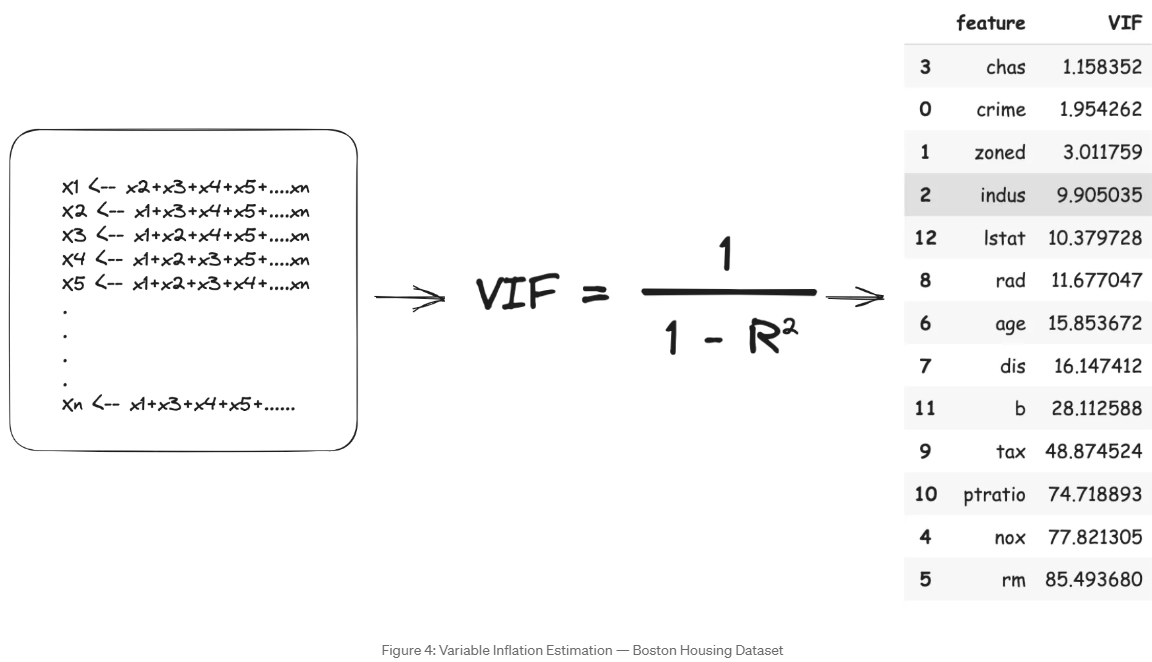

위의 VIF 추정치에 따르면, 상관관계를 완전히 해결하려면 13개의 IV 중 11개를 삭제해야 합니다.   
이렇게 하면 막대한 정보 손실이 발생할 뿐만 아니라 실제 환경에서 성능이 좋지 않은 과적합 또는 과소적합 모델을 생성할 수 있습니다.   


머신 러닝에서는 pairwise multi-correlation과 VIF 점수가 피처를 제거하거나 유지하는 유일한 기준이 되어서는 안 됩니다.   
어떤 피처는 상관관계와 VIF 점수가 높더라도 여전히 상당한 예측 가치를 제공하거나 모델 해석에 기여할 수 있습니다.

### Inflationary VS Predictive Costs to Collinear Feature Selection

정보 손실을 완화하기 위해 두 값을 비교하여 공선성 피처를 유지하는 데 드는 인플레이션 비용과 삭제하는 데 드는 예측 비용을 측정할 수 있다.    
VIF 분석은 타겟 변수와 독립적으로 수행되므로,  
타겟 변수에 대한 개별 IV의 독립적인 영향을 완전히 설명하지는 못한다는 점에 유의하자.

In [6]:
import statsmodels.api as sm

In [7]:
## Build Multiple Linear Regression models to access true independent influence on the outcome
fs = []
for feature in X.columns:
    model = sm.OLS(y, sm.add_constant(X[feature])).fit() # 선형회귀 모델
    fs.append((feature, model.params[feature]/model.pvalues[feature]))

In [8]:
fs

[('CRIM', -3.5365830187762104e+18),
 ('ZN', 2487755327428004.0),
 ('INDUS', -1.3233788738364454e+30),
 ('CHAS', 85867.68620324801),
 ('NOX', -4.800545700205568e+24),
 ('RM', 3.6595381660607816e+74),
 ('AGE', -7.844848210055269e+16),
 ('DIS', 90469286.10996656),
 ('RAD', -7.374686577563941e+17),
 ('TAX', -4.535173381801319e+26),
 ('PTRATIO', -1.3402687743769677e+34),
 ('B', 2548572610412.975),
 ('LSTAT', -1.869769772461909e+87)]

In [9]:
## Extract and Store Values
c1 = pd.DataFrame(fs, columns = ['Feature', 'VarianceEx']).sort_values("VarianceEx")

In [10]:
c1

,Feature,VarianceEx
12,LSTAT,-1.869770e+87
10,PTRATIO,-1.340269e+34
2,INDUS,-1.323379e+30
9,TAX,-4.535173e+26
4,NOX,-4.800546e+24
0,CRIM,-3.536583e+18
8,RAD,-7.374687e+17
6,AGE,-7.844848e+16
3,CHAS,8.586769e+04
7,DIS,9.046929e+07


--- 다시 볼 것

첫번째 측정 값은 타겟에 대한 입력 피처의 독립적인 영향력이다.(타겟 변수내의 분산의 크기??)   
일관성을 위해 이 R2 값에서 VIF 점수를 추정하고 이를 VIF(IY) - 독립 중요도라고 부릅니다.   

두 번째 측정값은 모든 IV가 있을 때 독립 변수가 종속 변수에 미치는 영향력, 즉 위에서 추정된 VIF입니다.   

이를 VIF(IX) - collective importance라고 부릅니다.

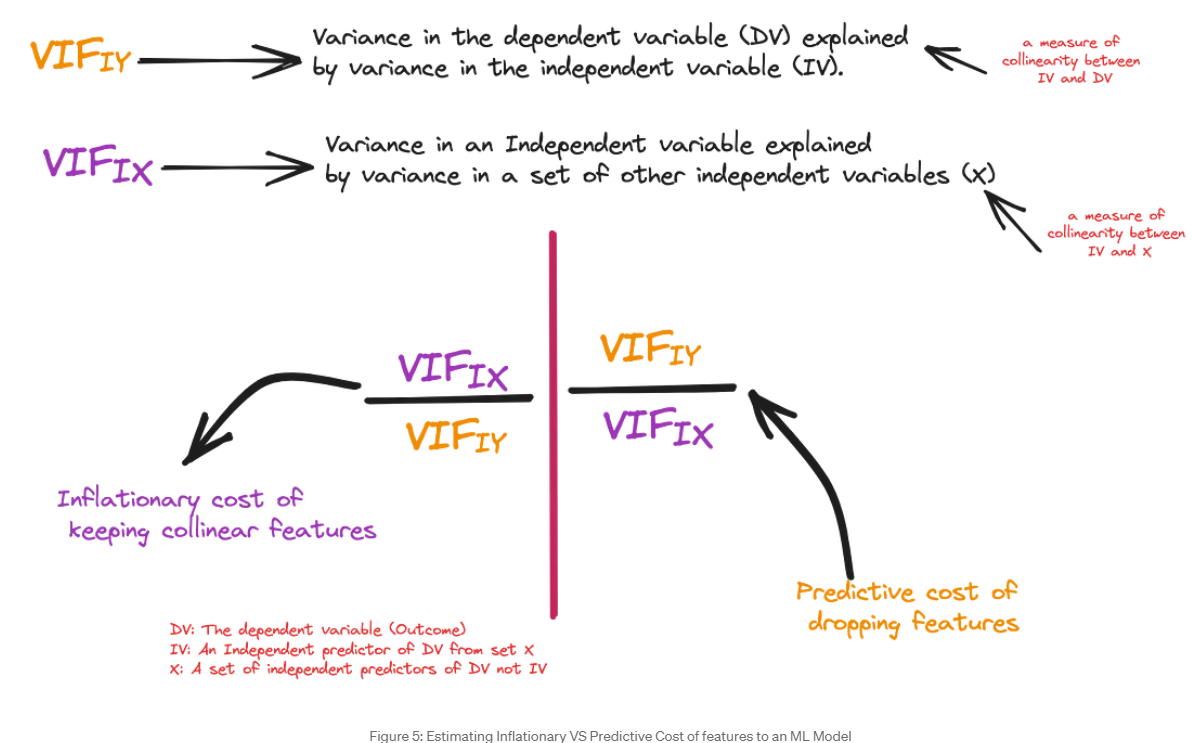

이제, 공선성 피처를 삭제함으로써 사용자가 놓치고 있는 '놀라움'의 실제 양을 자신 있게 추정할 수 있습니다.   
아래 그래프에서 X축은 각 IV가 설명하는 Y의 분산(예측에 대한 잠재적 '유용성'의 척도)을 나타내고,   
Y축은 다른 IV가 설명하는 IV의 분산(모델에 대한 잠재적 '편향성'의 척도)을 나타냅니다.   
subplot 1의 buble 크기는 이러한 피처를 모델에 유지하는 데 드는 인플레이션 비용이며,   
subplot 플롯 2는 이러한 피처를 삭제하는 데 드는 예측 비용입니다.

이 단계는 전처리 단계이므로 VIF(IX) 계수 20(빨간색 선)과 VIF(IY) 1.15(파란색 선)로 매우 느슨한 '컷오프'를 사용하겠습니다.   
따라서 빨간색 선 아래의 피처는 다른 IV에 의해 가장 적게 설명되고 파란색 선 뒤의 피처는 독립적으로 (Y)를 예측할 수 없습니다.

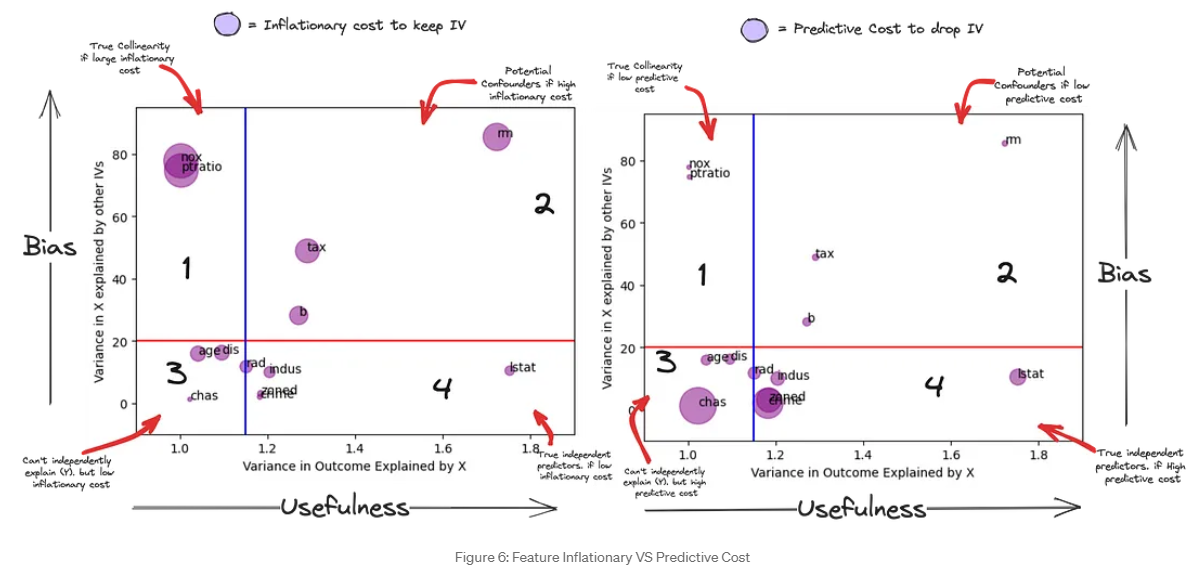

이 그래프는 IV의 독립적인 예측 능력과 bias 가능성을 요약한 것입니다.   

- 사분면 1 (잠재적으로 진정한 collinear): 이러한 피처(NOX, PTRATIO)는 모델에서 IV의 선형 조합으로 설명되며, 타겟 변수를 독립적으로 예측할 수 없습니다(다른 IV 세트에 의존해야 유용할 수 있음). 또한, 어떤 예측력을 가지고 있더라도 다른 IV의 선형 조합에 의해 상쇄될 수 있습니다(subplot 2). 다른 IV를 추가하면 그 영향력이 상당히 억제됩니다.   
- 사분면 2 (잠재적 편향성): 이는 타겟 피처 및 기타 독립 피처 모두와 관련이 있습니다. 특징(RM, TAX, B)은 (Y)를 독립적으로 예측하는 것처럼 보이지만 그 분산은 다른 독립 변수의 조합에 의해서도 설명됩니다. 소위 (Y)에 대한 독립적인 예측력은 다른 독립변수(IV)와 분리하여 고려할 수 없습니다. 결과에 대한 매우 강력한 예측 변수가 될 수도 있고 결과에 대한 중요성을 해석할 때 편향의 원인이 될 수도 있습니다.   
- 사분면 3 (종속변수): 종속변수는 (Y)를 독립적으로 예측하지는 않지만, 일부 종속변수를 제외할 경우 예측 비용이 높습니다. 이는 다른 IV로는 설명할 수 없는 고유한 정보를 가지고 있기 때문입니다. 이 '고유한' 정보가 (Y)를 예측하는 데 얼마나 유용한지는 다른 IV와 함께 고려할 때만 고려할 수 있습니다.  
- 사분면 4 (진정한 독립 예측 변수) : 이러한 변수는 (Y)를 독립적으로 예측합니다. 이러한 변수에는 다른 IV(사분면 3 이상)로는 설명되지 않는 고유한 정보도 있습니다. 이 '고유' 정보의 (Y) 예측에 대한 유용성은 다른 IV와 독립적입니다. 그러나 다른 IV의 선형 조합은 독립적인 예측보다 더 높은 예측력을 가질 수 있습니다.

In [11]:
O = y
# To estimate the effect the addition/removal of a feature C
# has on the relationship between an independent feature I and an outcome O

conf = []
for I in X.columns:
    # build a baseline model for the  effect of I on  O
    model = sm.OLS(O, sm.add_constant(X[I])).fit()
    IO_coef, IO_sig = model.params[I], model.pvalues[I]

    ## Access the effect of 
    for C in X.columns:
        if C != I:
            # build an auxilliary model adding C to the relationship between I and O
            model2 = sm.OLS(O, sm.add_constant(X[[I, C]])).fit()
            ico_preds = model2.predict()
            ICO_coef, ICO_sig = model2.params[I], model2.pvalues[I]

            # build a baseline model for the effect of C on  O
            model3 = sm.OLS(O, sm.add_constant(X[C])).fit()
            CO_coef, CO_sig = model3.params[C], model3.pvalues[C]

            corr_IC, _ = stats.pearsonr(X[I], X[C]) # CORR The independent vs the control
            corr_IO, _ = stats.pearsonr(X[I], O) #CORR The independent vs the outcome
            corr_CO, _ = stats.pearsonr(X[C], O) #CORR The control vs the outcome
            conf.append({"I_C":f"{I}_{C}",
                                "IO_coef":IO_coef, "IO_sig":IO_sig,
                                "CO_coef":CO_coef, "CO_sig":CO_sig,
                                "ICO_sig":ICO_sig, "ICO_coef": ICO_coef,
                                "corr_IC":corr_IC,
                                "corr_IO":corr_IO,
                                "corr_CO":corr_CO})

In [12]:
cc = pd.DataFrame(conf)
corr_ic = (cc['corr_IC'] > 0.5) | (cc['corr_IC'] < -0.5) # I is correlated with C
corr_co = (cc['corr_CO'] > 0.5) | (cc['corr_CO'] < -0.5) # C is correlated with O
corr_io = (cc['corr_IO'] > 0.5) | (cc['corr_IO'] < -0.5) # C is correlated with O

## C and O are significantly correlated
co_sig = (cc['CO_sig'] < 0.01) # The C is independetly predictive of O
io_sig = (cc['IO_sig'] < 0.01)

cc[corr_ic & corr_io & corr_co & co_sig & io_sig]

,I_C,IO_coef,IO_sig,CO_coef,CO_sig,ICO_sig,ICO_coef,corr_IC,corr_IO,corr_CO
71,RM_LSTAT,9.102109,2.487229e-74,-0.950049,5.081103e-88,3.472258e-27,5.094788,-0.613808,0.695360,-0.737663
149,LSTAT_RM,-0.950049,5.081103e-88,9.102109,2.487229e-74,6.669365e-41,-0.642358,-0.613808,-0.737663,0.695360


In [13]:
cc

,I_C,IO_coef,IO_sig,CO_coef,CO_sig,ICO_sig,ICO_coef,corr_IC,corr_IO,corr_CO
0,CRIM_ZN,-0.415190,1.173987e-19,0.142140,5.713584e-17,1.236236e-15,-0.352078,-0.200469,-0.388305,0.360445
1,CRIM_INDUS,-0.415190,1.173987e-19,-0.648490,4.900260e-31,4.985079e-08,-0.245478,0.406583,-0.388305,-0.483725
2,CRIM_CHAS,-0.415190,1.173987e-19,6.346157,7.390623e-05,2.699189e-19,-0.405985,-0.055892,-0.388305,0.175260
3,CRIM_NOX,-0.415190,1.173987e-19,-33.916055,7.065042e-24,6.945034e-09,-0.270843,0.420972,-0.388305,-0.427321
4,CRIM_RM,-0.415190,1.173987e-19,9.102109,2.487229e-74,8.002658e-15,-0.264913,-0.219247,-0.388305,0.695360
...,...,...,...,...,...,...,...,...,...,...
151,LSTAT_DIS,-0.950049,5.081103e-88,1.091613,1.206612e-08,3.203580e-85,-1.049240,-0.496996,-0.737663,0.249929
152,LSTAT_RAD,-0.950049,5.081103e-88,-0.403095,5.465933e-19,9.143622e-71,-0.932564,0.488676,-0.737663,-0.381626
153,LSTAT_TAX,-0.950049,5.081103e-88,-0.025568,5.637734e-29,2.833497e-62,-0.883127,0.543993,-0.737663,-0.468536
154,LSTAT_PTRATIO,-0.950049,5.081103e-88,-2.157175,1.609509e-34,2.347200e-71,-0.820180,0.374044,-0.737663,-0.507787


변수 B , TAX 및 RM은 서로를 유의미하게 예측하며 독립적으로 결과를 예측합니다.   
이는 DV(MEDV)를 가장 잘 예측하는 IV의 선형 조합일 수 있습니다.  
또는 세 번째 IV의 존재로 인해 이 두 IV의 예측 관련성이 부풀려지거나 억제될 수 있습니다.  
이를 조사하려면 모든 독립 변수로 구성된 기준 모델에서 각 변수를 순차적으로 제거해야 합니다.

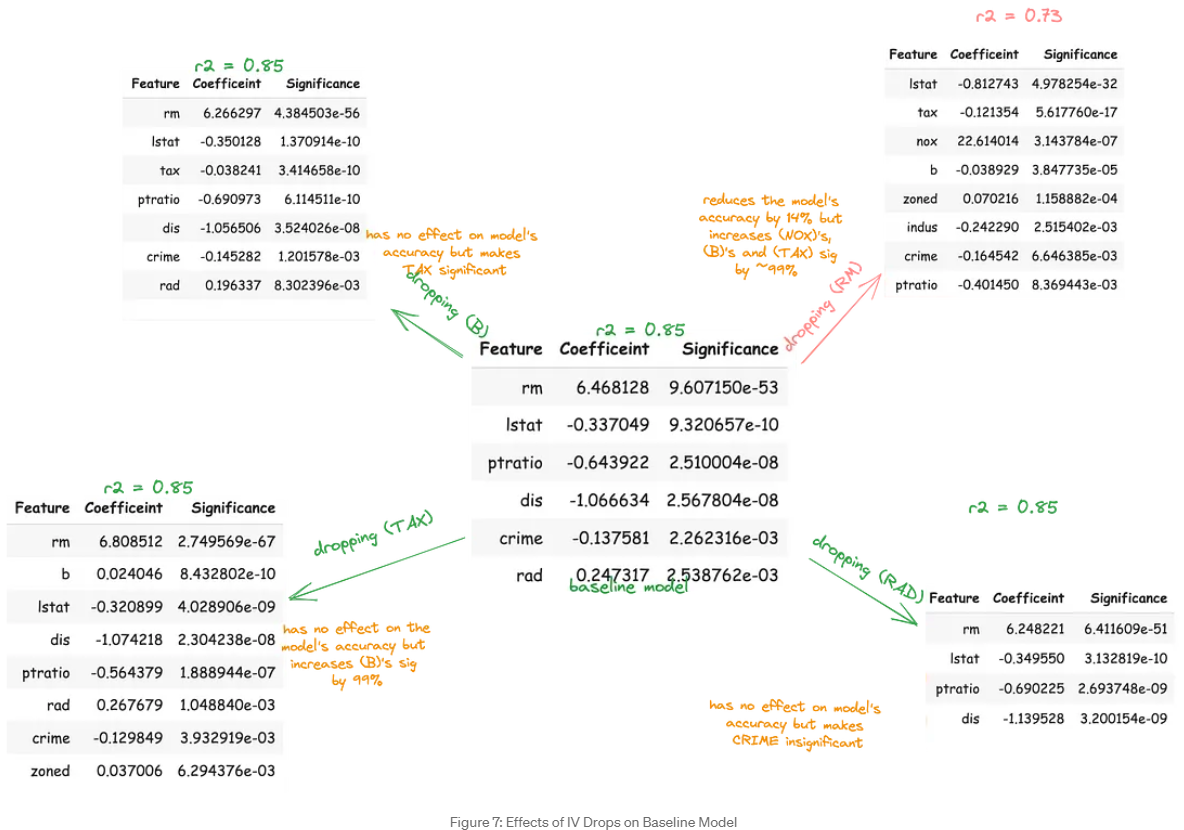

그 후 결과에 대한 나머지 변수의 중요도 변화에 상응하는 변화를 백분율로 정량화해야 합니다.  
이 절차는 다른 IV가 설명하는 IV를 중요한 척 노출하는 데 도움이 됩니다.??  

Subsequently, the corresponding change in the significance of the remaining variables on the outcome should be quantified in terms of percentage. This procedure will help expose IVs explained by other IVs, pretending to be important.

### Above the redline, removing collinear bias

There are three main effects (of concern) collinear variables above the red line may have on the relationship between other IV(s) and the dependent variable. They may mediate (suppress), confound (exaggerate) or moderate (change).

The concepts of moderators, mediators and confounders is not really discussed in Machine Learning. These concepts are often left to the ‘social scientists’, after all, they are ones who ever need to ‘interprete’ their coefficients. However, these concepts explain how collinearity can introduce bias to ML models.

Note that these effects cannot be truly established without deeper causal analysis, but for a bias removal pre-processing step, we can use simple definitions of these concepts to filter these relationships.

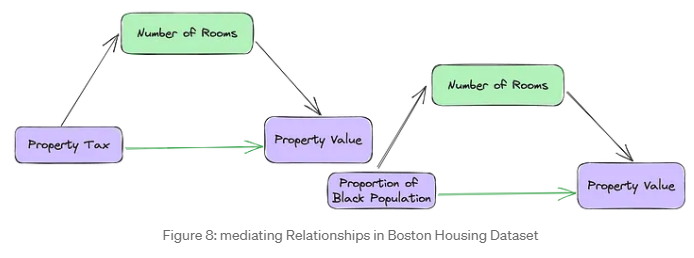

mediator는 IV와 DV가 '어떻게' 연관되는지, 즉 연관되는 과정을 설명합니다.  
mediator는 세 가지 기준을 충족해야 합니다:

- a) 첫 번째 IV를 유의미하게 예측할 것,  
- b) 종속 변수를 유의미하게 예측할 것, 
- c) 첫 번째 IV가 있을 때 종속 변수를 유의미하게 예측할 것.

매개 변수를 포함해도 첫 번째 IV와 종속 변수 간의 관계 방향이 바뀌지 않기 때문에 '매개' 역할을 합니다.   
모델에서 매개 변수를 제거하면 매개 변수가 실제로 해당 효과의 일부를 설명하기 때문에 첫 번째 IV와 종속 변수 간의 관계의 강도가 더 강해집니다.

In [14]:
## finding mediators
cc = pd.DataFrame(conf)
co_sig = (cc['CO_sig'] < 0.01) # The C is independetly predictive of Y
io_sig = (cc['IO_sig'] < 0.01) # The I is independetly predictive of Y
icoi_sig = (cc['ICO_I_sig'] < 0.01) # The I  and C are predictive of Y
icoc_sig = (cc['ICO_C_sig'] < 0.05) # The C is independetly predictive of Y in the presence of I
icoci_sig = (cc['IO_sig'] > cc['ICO_I_sig']) # Direct relationship between I and O should be stronger without C

KeyError: 'ICO_I_sig'

... 이상